In [419]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from prophet import Prophet 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats.mstats import winsorize

import warnings
warnings.simplefilter('ignore')

**Data Loading**

In [420]:
df_dept = pd.read_excel("/Users/jothiprakash/Documents/Course/Final Project/Data/After midterm /DeptHours.xlsx",sheet_name ='Dept')
df_dept.head()

,Pos,FormatDate,EmployeeID,Date,MinOfFrom Time,MaxOfTo Time,SumOfHours,RegHours Portion,OT Portion,Dept ID,SchBreaks,ProductionHours
0,FT,2021/01/01,103,2021-01-01,2021-01-01 07:30:00,2021-01-01 19:30:00,12.0,8.0,4.0,Dept006,2.0,10.0
1,FT,2021/01/01,1008,2021-01-01,2021-01-01 08:30:00,2021-01-01 16:00:00,7.5,7.5,0.0,Dept001,1.0,6.5
2,FT,2021/01/01,310,2021-01-01,2021-01-01 19:30:00,2021-01-02 07:30:00,12.0,8.0,4.0,Dept006,2.0,10.0
3,FT,2021/01/01,474,2021-01-01,2021-01-01 19:30:00,2021-01-02 07:30:00,12.0,8.0,4.0,Dept006,2.0,10.0
4,FT,2021/01/02,87,2021-01-02,2021-01-02 07:30:00,2021-01-02 19:30:00,12.0,0.0,12.0,Dept006,1.0,11.0


In [421]:
df_comp = pd.read_excel("/Users/jothiprakash/Documents/Course/Final Project/Data/After midterm /dept_prod.xlsx",sheet_name ='int_comp')

df_comp.head()

,DateofShiftStart,DateRef,IntervalID,GreenshieldIntervalOrder,Interval Start,EmployeeID,Code,Item Desciption,Type,Transactions,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,2023-07-24,0,31,19,07:45:00,607,NW,ItemType01,SU,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-07-24,0,31,19,07:45:00,407,NW,ItemType01,SU,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-07-24,0,31,19,07:45:00,233,NW,ItemType02,SU,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-07-24,0,31,19,07:45:00,661,NW,ItemType02,SU,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-07-24,0,31,19,07:45:00,1470,NW,ItemType03,SU,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Data Cleaning** 

In [422]:
#Dropping NA values and unused columns

df_comp = df_comp.dropna(axis=1, how='any')

df_dept = df_dept.dropna()

df_dept = df_dept.drop(['Pos', 'FormatDate'], axis=1)

In [423]:
# Getting Range of active employee date from production completion

df_comp['DateofShiftStart'] = pd.to_datetime(df_comp['DateofShiftStart'])

earliest_date = df_comp['DateofShiftStart'].min()
latest_date = df_comp['DateofShiftStart'].max()

In [424]:
# Implementing the range for the employee punch in and out 

df_dept['Date'] = pd.to_datetime(df_dept['Date'])

df_dept_act = df_dept[(df_dept['Date'] >= earliest_date) & (df_dept['Date'] <= latest_date)]


In [425]:
df_comp_grp = df_comp.groupby(['DateofShiftStart','EmployeeID','Item Desciption']).sum()
df_comp_grp.reset_index(inplace = True)

In [426]:
df_comp_grp

,DateofShiftStart,EmployeeID,Item Desciption,DateRef,IntervalID,GreenshieldIntervalOrder,Transactions
0,2023-07-24,-1,ItemType01,0,3156,2484,451
1,2023-07-24,-1,ItemType02,0,481,385,10
2,2023-07-24,-1,ItemType04,0,200,140,25
3,2023-07-24,-1,ItemType06,0,568,424,17
4,2023-07-24,-1,ItemType09,0,57,45,1
...,...,...,...,...,...,...,...
33968,2023-11-14,2699,ItemType01,0,146,122,4
33969,2023-11-14,2699,ItemType03,0,78,66,5
33970,2023-11-14,2700,ItemType01,0,148,124,2
33971,2023-11-14,2700,ItemType03,0,111,87,2


In [427]:
df_comp_grp.columns = ['Date','EmployeeID','Item','DateRef','IntervalID','GreenshieldIntervalOrder','Transactions']

In [428]:
df_dept_act_grp = df_dept.groupby(['Date','EmployeeID','Dept ID']).sum()
df_dept_act_grp.reset_index(inplace = True)

In [429]:
merged_data = pd.merge(df_comp_grp,df_dept_act_grp,on=['EmployeeID','Date'],how ='inner')

In [430]:
refined_data = merged_data[['Date','EmployeeID','Dept ID','Item','ProductionHours','Transactions']]
refined_data

,Date,EmployeeID,Dept ID,Item,ProductionHours,Transactions
0,2023-07-24,88,Dept002,ItemType04,7.0,12
1,2023-07-24,160,Dept002,ItemType01,7.0,8
2,2023-07-24,160,Dept002,ItemType02,7.0,12
3,2023-07-24,187,Dept002,ItemType01,4.0,107
4,2023-07-24,187,Dept002,ItemType02,4.0,3
...,...,...,...,...,...,...
30710,2023-11-14,2699,Dept001,ItemType01,6.5,4
30711,2023-11-14,2699,Dept001,ItemType03,6.5,5
30712,2023-11-14,2700,Dept001,ItemType01,6.5,2
30713,2023-11-14,2700,Dept001,ItemType03,6.5,2


In [431]:
#Only Dept001 - Dept004 was working transcations

refined_data['Dept ID'].unique()

array(['Dept002', 'Dept001', 'Dept003', 'Dept004'], dtype=object)

In [432]:
refined_data.EmployeeID.nunique()

335

In [433]:
refined_data['Item'].unique()
#No ItemType07

array(['ItemType04', 'ItemType01', 'ItemType02', 'ItemType03',
       'ItemType10', 'ItemType05', 'ItemType06', 'ItemType09',
       'ItemType08', 'ItemType12', 'ItemType11', 'ItemType18',
       'ItemType13', 'ItemType14', 'ItemType15', 'ItemType16',
       'ItemType17', 'ItemType19'], dtype=object)

In [466]:
replacement_map = {
    'ItemType01': 1, 'ItemType02': 2, 'ItemType03': 3, 'ItemType04': 4,
    'ItemType05': 5, 'ItemType06': 6, 'ItemType07': 7, 'ItemType08': 8,
    'ItemType09': 9, 'ItemType10': 10, 'ItemType11': 11, 'ItemType12': 12,
    'ItemType13': 13, 'ItemType14': 14, 'ItemType15': 15, 'ItemType16': 16,
    'ItemType17': 17, 'ItemType18': 18, 'ItemType19': 19
}
refined_data['Item'] = refined_data['Item'].replace(replacement_map)


In [467]:
#One employee is working on only one departments,So no duplicate values in the outcome.
dept_ = refined_data[refined_data.duplicated(subset =['Date','EmployeeID','Dept ID','Item'])]
dept_

,Date,EmployeeID,Dept ID,Item,ProductionHours,Transactions


In [468]:
#dropping rows based on outliers
dates_to_remove = ['2023-12-22','2022-12-30', '2023-08-11','2023-12-01']
dates_to_remove = pd.to_datetime(dates_to_remove)
refined_data = refined_data[~refined_data['Date'].isin(dates_to_remove)]

In [469]:
refined_data.to_excel('refined_data.xlsx', index=False)

# Functions to handle modles based on Department and Employee


In [686]:
count = refined_data.groupby('EmployeeID').count().reset_index()
count.sort_values('Date', ascending=False)['EmployeeID']

192    1294
100     733
77      633
142    1036
230    1454
       ... 
305    2590
269    2407
289    2556
333    2701
330    2691
Name: EmployeeID, Length: 334, dtype: int64

In [470]:
def handling_empID(ID):
    emp_data = refined_data[refined_data['EmployeeID']==ID]
    emp_data.drop(columns = ['Dept ID','EmployeeID'], inplace =True)
    emp_data.reset_index(inplace = True)

    return emp_data

In [778]:
employee = handling_empID(1294)
                         
employee.drop(columns = ['index'],inplace = True)
employee

,Date,Item,ProductionHours,Transactions
0,2023-07-24,1,7.0,6
1,2023-07-24,4,7.0,3
2,2023-07-24,6,7.0,1
3,2023-07-24,9,7.0,1
4,2023-07-24,18,7.0,20
...,...,...,...,...
401,2023-11-14,1,7.0,30
402,2023-11-14,2,7.0,10
403,2023-11-14,4,7.0,15
404,2023-11-14,6,7.0,8


In [779]:
employee.to_excel('employee1294.xlsx', index=False)

In [780]:
def handling_dept(dept):
    dept_data = refined_data[refined_data['Dept ID']==dept]
    dept_data = dept_data.groupby(['Date','Item']).sum()
    dept_data.drop(columns = 'EmployeeID',inplace = True)
    dept_data.reset_index(inplace = True)
    
    return dept_data

In [781]:
department = handling_dept('Dept002')
department

,Date,Item,ProductionHours,Transactions
0,2023-07-24,1,262.75,2054
1,2023-07-24,2,244.75,1018
2,2023-07-24,3,156.75,272
3,2023-07-24,4,117.50,1639
4,2023-07-24,5,67.25,1034
...,...,...,...,...
1180,2023-11-14,11,14.00,138
1181,2023-11-14,13,7.00,29
1182,2023-11-14,14,7.00,3
1183,2023-11-14,15,14.00,17


In [782]:
department.to_excel('department002.xlsx', index=False)

# Data Spliting and Encoding

In [783]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

In [784]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

df = employee


df['DayOfWeek'] = df['Date'].dt.dayofweek
df = df.drop(['Date'], axis=1)
# Define X and y
X = df.drop('Transactions', axis=1)
y = df['Transactions']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['ProductionHours']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Item', 'DayOfWeek'])
    ])


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply transformations
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


item_encoder = preprocessor.named_transformers_['cat']

# Now, get the list of categories for 'Item'
fitted_categories_item = item_encoder.categories_[0]
fitted_categories_day = item_encoder.categories_[1]

print(f"Fitted categories for 'Item': {fitted_categories_item}")
print(f"Fitted categories for 'day': {fitted_categories_day}")

Fitted categories for 'Item': [ 1  2  3  4  6  9 18]
Fitted categories for 'day': [0 1 2 3 4 5 6]


# Finding Right model 

In [785]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sklearn.model_selection
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

In [786]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))

In [787]:
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = KFold(n_splits=10, random_state=7, shuffle=True)
	cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LR: 0.145122 (0.045794)
LDA: 0.160000 (0.054361)
KNN: 0.122805 (0.046037)
CART: 0.110305 (0.058759)
NB: 0.078780 (0.046537)
SVM: 0.162622 (0.062201)
RF: 0.120122 (0.057699)


# DNN model

In [788]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Get the number of features after preprocessing
input_shape = X_train_transformed.shape[1]

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(input_shape,)),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


# Convert the transformed training and testing sets to dense arrays
X_train_transformed_dense = X_train_transformed.toarray()
X_test_transformed_dense = X_test_transformed.toarray()

# Proceed to define and compile your model here as before

# Train the model with the dense array
model.fit(X_train_transformed_dense, y_train, epochs=45, batch_size=32, verbose=1, validation_split=0.2)
y_pred = model.predict(X_test_transformed.toarray())

Epoch 1/45
9/9 [==============================] - 0s 9ms/step - loss: 777.6142 - val_loss: 368.8966
Epoch 2/45
9/9 [==============================] - 0s 3ms/step - loss: 760.3291 - val_loss: 357.3949
Epoch 3/45
9/9 [==============================] - 0s 2ms/step - loss: 743.6239 - val_loss: 343.5724
Epoch 4/45
9/9 [==============================] - 0s 2ms/step - loss: 722.1097 - val_loss: 326.8067
Epoch 5/45
9/9 [==============================] - 0s 2ms/step - loss: 697.4116 - val_loss: 305.6182
Epoch 6/45
9/9 [==============================] - 0s 2ms/step - loss: 665.8519 - val_loss: 281.9050
Epoch 7/45
9/9 [==============================] - 0s 2ms/step - loss: 630.0052 - val_loss: 255.0652
Epoch 8/45
9/9 [==============================] - 0s 2ms/step - loss: 587.3242 - val_loss: 227.1197
Epoch 9/45
9/9 [==============================] - 0s 2ms/step - loss: 545.7042 - val_loss: 200.6161
Epoch 10/45
9/9 [==============================] - 0s 2ms/step - loss: 500.3747 - val_loss: 180.6904

In [789]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate R² score
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r2}")


Mean Absolute Error (MAE): 6.227675829718753
Mean Squared Error (MSE): 63.971838236174044
Root Mean Squared Error (RMSE): 7.9982396960940125
R-squared (R²): 0.7756194884198959


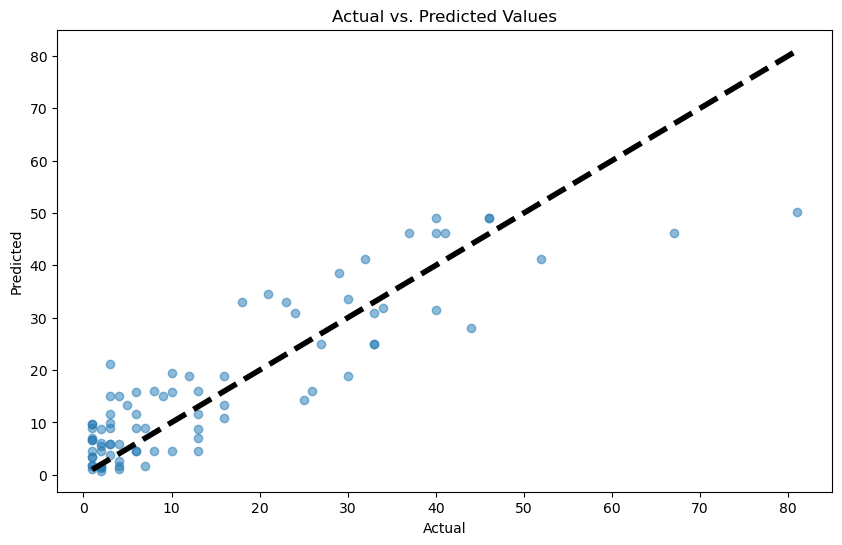

In [790]:
import matplotlib.pyplot as plt

# Assuming y_test_pred are your predictions on the test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()


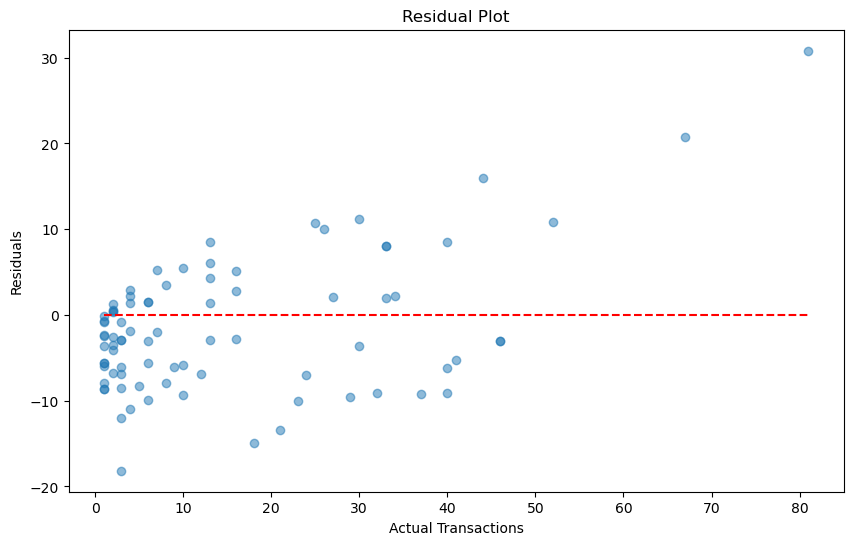

In [791]:
residuals = y_test - y_pred.flatten()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max(), colors='red', linestyles='--')
plt.xlabel('Actual Transactions')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


In [797]:

input_value = {'Date': '2024-04-10', 'Item': 1, 'ProductionHours': 7}

# Convert the input into a DataFrame
input_df = pd.DataFrame([input_value])
input_df['Date'] = pd.to_datetime(input_df['Date'])
input_df['DayOfWeek'] = input_df['Date'].dt.dayofweek
input_df.drop('Date', axis=1, inplace=True)

# Assuming 'fitted_categories_item' is a list of categories seen during training for 'Item'
# Let's correct the check for unseen categories
item = input_df['Item']
unseen_categories = set(item) - set(fitted_categories_item)  # Use the correct variable name

if unseen_categories:
    print(f"Unseen categories in 'Item': {unseen_categories}.")
else:
    # Proceed with transformation
    # Ensure to convert input_df according to your preprocessor requirements
    input_transformed = preprocessor.transform(input_df)

    # Predict
    predicted_transactions = model.predict(input_transformed)
    print(f"Predicted Transactions: {predicted_transactions[0]}")


1/1 [==============================] - 0s 5ms/step
Predicted Transactions: [17.422888]
